# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

## About This Notebook  
This notebook processes the `bureau.csv` dataset, which contains applicants' credit history.  
Processed features will be merged into the main dataset (`application_train.csv`) for model training.

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb) _(Current Notebook)_  
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb)  

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  _(Current Notebook)_
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb)  
- [6. Previous Applications](./06_previous_applications.ipynb)  
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb)  
- [8. Installments Payments](./08_installments_payments.ipynb)  

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)

# Processing `bureau.csv` (Credit Bureau Data)

## 1. Load Data (`bureau.csv`)
We start by loading the dataset and inspecting its structure to understand its key features and statistics.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset 
df_bureau = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")

## 2. Initial Data Inspection (`bureau.csv`)
Before processing, we inspect the dataset for potential issues such as **infinite values**, **missing values**, and other inconsistencies.

### 2.1 Checking for Infinite Values  
Infinite values (e.g., `inf`, `-inf`) can break numerical calculations and should be identified before proceeding.  
The code below scans for any **positive or negative infinite values** in the dataset.  

In [3]:
# Check for infinite values
print("Checking for infinite values in dataset...")
inf_count = (df_bureau == np.inf).sum().sum()
neg_inf_count = (df_bureau == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

Checking for infinite values in dataset...
✅ No infinite values detected.


### 2.2 Checking for Missing Values (NaNs)  
Missing values (**NaNs**) can affect model performance and should be handled properly.  
Here, we count the number of missing values in each column and print the results.

In [4]:
# Check for missing values
missing_values = df_bureau.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_ANNUITY               1226791
dtype: int64


### 2.3 Print Dataset Columns  
To get an overview of the dataset structure, we print the column names.  
This helps us understand the available features and identify any inconsistencies.

In [5]:
# Print dataset columns
print(df_bureau.columns)

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


### 2.4 Detecting Extreme Values (Outliers)  

Extreme values (**outliers**) can skew model performance and lead to **unstable predictions**.  
We detect outliers using **percentile thresholds**:  

- **Above the 99th percentile** → Very large values.  
- **Below the 1st percentile** → Very small values.  

In [6]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'bureau' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_CURR', 'SK_ID_BUREAU']
extreme_numeric_columns = df_bureau.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'bureau' dataset.")


Checking for extreme values in 'bureau' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
DAYS_CREDIT               0.000000e+00
CREDIT_DAY_OVERDUE        2.792000e+03
DAYS_CREDIT_ENDDATE       3.119900e+04
DAYS_ENDDATE_FACT         0.000000e+00
AMT_CREDIT_MAX_OVERDUE    1.159872e+08
CNT_CREDIT_PROLONG        9.000000e+00
AMT_CREDIT_SUM            5.850000e+08
AMT_CREDIT_SUM_DEBT       1.701000e+08
AMT_CREDIT_SUM_LIMIT      4.705600e+06
AMT_CREDIT_SUM_OVERDUE    3.756681e+06
DAYS_CREDIT_UPDATE        3.720000e+02
AMT_ANNUITY               1.184534e+08
dtype: float64
⚠️ Columns with very small values (below 1st percentile):
DAYS_CREDIT               -2922.000
DAYS_CREDIT_ENDDATE      -42060.000
DAYS_ENDDATE_FACT        -42023.000
AMT_CREDIT_SUM_DEBT    -4705600.320
AMT_CREDIT_SUM_LIMIT    -586406.115
DAYS_CREDIT_UPDATE       -41947.000
dtype: float64


### 2.5 Checking Dataset Shape  

The dataset's shape provides a quick view of its size, showing the number of **rows** (loan records) and **columns** (features).  

In [7]:
# Check the shape of the dataset
print("DataFrame Shape:", df_bureau.shape)

DataFrame Shape: (1716428, 17)


### 2.6 Viewing Sample Data (`head()`)  

To understand the dataset, we display the **first few rows**.  
This helps verify that data is loaded correctly and gives an initial sense of feature distributions.  

In [8]:
print("First few rows of bureau DataFrame:")
display(df_bureau.head())

First few rows of bureau DataFrame:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### 2.7 Dataset Summary (`info()`)  

The `info()` function provides:  
- **Column names and types** (e.g., integer, float, categorical).  
- **Non-null counts** (to check for missing data).  
- **Memory usage**, which is useful for optimizing performance.  

In [9]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_bureau.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


### 2.8 Descriptive Statistics  

We generate summary statistics for:  
- **Numeric columns** (`describe()`) → Mean, standard deviation, min/max, and quartiles.  
- **Categorical columns** (`describe(include='object')`) → Count of unique values, most frequent categories.  
This helps in **understanding distributions** and identifying possible anomalies.  

In [10]:
# Get summary statistics of numeric columns
print("Descriptive Statistics:")
display(df_bureau.describe())
display(df_bureau.describe(include="object"))

Descriptive Statistics:


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


## 3. Initial Data Cleaning (`bureau.csv`)  
After identifying potential issues, we clean the dataset by handling **infinite values, categorical features, and potential misclassified columns**.

### 3.1 Replacing Infinite Values  
Since infinite values (`inf`, `-inf`) can interfere with model training, we replace them with `NaN` to handle them properly later.  

In [11]:
# Replace infinite values with NaN before handling missing values
df_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


### 3.2 Converting Categorical Features  
Some columns are stored as `object` or numeric types but should be categorical.  
We identify and convert relevant columns to the **category dtype** for efficiency and proper encoding.  

In [12]:
# Convert manually identified categorical columns
categorical_cols = ["CREDIT_ACTIVE", "CREDIT_CURRENCY", "CREDIT_TYPE"]
df_bureau[categorical_cols] = df_bureau[categorical_cols].astype("category")

print("✅ Converted manually identified categorical columns to 'category'.")

✅ Converted manually identified categorical columns to 'category'.


### 3.3 Checking Unique Values in Categorical Columns  
To ensure correct data types, we print the number of unique values in categorical columns.  
This helps verify if any unexpected categories exist.  

In [13]:
print("Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_bureau[col].nunique()} unique values")

Unique values in categorical columns:
CREDIT_ACTIVE: 4 unique values
CREDIT_CURRENCY: 4 unique values
CREDIT_TYPE: 15 unique values


### 3.4 Detecting Potentially Misclassified Features  
Some numeric columns may actually be categorical (e.g., if they have a small number of unique values).  
To detect them, we check numeric columns with **low cardinality** and convert them if necessary.  

In [14]:
numeric_cols = df_bureau.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Unique values in numeric columns (checking for potential misclassified categoricals):")
for col in numeric_cols:
    unique_values = df_bureau[col].nunique()
    if unique_values < 20:  # Arbitrary threshold: If <20 unique values, it might be categorical
        print(f"⚠️ {col} has only {unique_values} unique values. It might be categorical.")

Unique values in numeric columns (checking for potential misclassified categoricals):
⚠️ CNT_CREDIT_PROLONG has only 10 unique values. It might be categorical.


In [15]:
df_bureau["CNT_CREDIT_PROLONG"] = df_bureau["CNT_CREDIT_PROLONG"].astype("category")
print("✅ Converted `CNT_CREDIT_PROLONG` to 'category' dtype.")

✅ Converted `CNT_CREDIT_PROLONG` to 'category' dtype.


### 3.5 Checking for Unexpected Object Columns  
Finally, we check if any unexpected `object` columns exist that should be converted or removed.  

In [16]:
object_cols = df_bureau.select_dtypes(include=['object']).columns.tolist()

if object_cols:
    print("⚠️ Unexpected object-type columns found:", object_cols)
else:
    print("✅ No unexpected object columns found.")

✅ No unexpected object columns found.


### 3.6 Displaying Updated Data Types  

After data cleaning, we check if all columns have the correct data types.  
This ensures that categorical, numeric, and ID columns are properly assigned before further processing.  

In [17]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_bureau.dtypes)
pd.reset_option('display.max_rows')  

✅ Updated Data Types:
SK_ID_CURR                   int64
SK_ID_BUREAU                 int64
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT                  int64
CREDIT_DAY_OVERDUE           int64
DAYS_CREDIT_ENDDATE        float64
DAYS_ENDDATE_FACT          float64
AMT_CREDIT_MAX_OVERDUE     float64
CNT_CREDIT_PROLONG        category
AMT_CREDIT_SUM             float64
AMT_CREDIT_SUM_DEBT        float64
AMT_CREDIT_SUM_LIMIT       float64
AMT_CREDIT_SUM_OVERDUE     float64
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE           int64
AMT_ANNUITY                float64
dtype: object


### 3.7 Handling Missing Values  
Missing values can impact model performance, so we analyze and handle them based on their percentage.  

#### 3.7.1 Checking for Missing Values  
We first identify missing values in each column to understand their distribution.  

In [18]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("Missing values in each column:")
print(df_bureau.isnull().sum())
pd.reset_option('display.max_rows')  

Missing values in each column:
SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64


#### 3.7.2 Calculating Missing Value Percentages  
To categorize missing values, we define thresholds:  
- **Low**: Less than 1% missing (likely safe to fill with median/mean).  
- **Moderate**: 1%–20% missing (requires careful handling).  
- **High**: More than 50% missing (usually dropped unless critical).  

In [19]:
# Define missing value thresholds 
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_bureau.isnull().sum() / len(df_bureau)) * 100  

# Display missing percentages
print("Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")) 

Missing Value Percentages:


AMT_ANNUITY               71.47%
AMT_CREDIT_MAX_OVERDUE    65.51%
DAYS_ENDDATE_FACT         36.92%
AMT_CREDIT_SUM_LIMIT      34.48%
AMT_CREDIT_SUM_DEBT       15.01%
DAYS_CREDIT_ENDDATE        6.15%
AMT_CREDIT_SUM             0.00%
dtype: object

#### 3.7.3 Dropping Columns with Excessive Missing Data  
Columns with **more than 50% missing values** are removed to prevent data leakage and reduce noise.  

In [20]:
# Identify columns to drop (more than 50% missing values)
columns_to_drop = missing_percent[missing_percent > high_threshold].index

# Drop columns
df_bureau.drop(columns=columns_to_drop, inplace=True)

print(f"✅ Dropped {len(columns_to_drop)} columns with more than 50% missing values.")

✅ Dropped 2 columns with more than 50% missing values.


#### 3.8 Filling Missing Values  

To ensure data completeness, we fill missing values in both **numeric** and **categorical** columns using appropriate strategies.  
- **Numeric values** → Filled with **median** (robust to outliers).  
- **Categorical values** → Filled with **mode** (most frequent category).  

In [21]:
# Fill numeric columns with median
numeric_cols_to_fill = df_bureau.select_dtypes(include=['int64', 'float64']).columns
df_bureau[numeric_cols_to_fill] = df_bureau[numeric_cols_to_fill].fillna(df_bureau[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


In [22]:
# Fill categorical columns with mode
categorical_cols_to_fill = df_bureau.select_dtypes(include=['category']).columns
for col in categorical_cols_to_fill:
    df_bureau[col] = df_bureau[col].fillna(df_bureau[col].mode()[0])  # ✅ Fixes the warning

print("✅ Filled categorical missing values with mode.")

✅ Filled categorical missing values with mode.


#### 3.9 Final Missing Values Check  
After filling missing values, we perform a final check to confirm that **no NaNs remain** in the dataset.  

In [23]:
print("Final Missing Values Check:")
print(df_bureau.isnull().sum().sum())

Final Missing Values Check:
0


#### 3.10 Checking for Duplicates  
Duplicate rows can cause data leakage and distort model training.  
We check for duplicates and ensure that no redundant rows exist.  

In [24]:
# Check for duplicates
print("Number of duplicate rows:", df_bureau.duplicated().sum())

Number of duplicate rows: 0


### 3.11 Saving the Cleaned Dataset  

Before saving, we **verify all column data types** to ensure correctness after processing.  

We save the cleaned dataset for two key purposes:  

**1. Mapping with `bureau_balance.csv`** → The `bureau_balance` dataset lacks `SK_ID_CURR` (main ID), so we use this cleaned file for proper merging.  

**2. Feature Ranges for Dummy Data** → This dataset is later used in the **Angular + Flask app** to generate test data for predictions.  

In [25]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types for df_bureau:")
print(df_bureau.dtypes)
pd.reset_option('display.max_rows')  

✅ Updated Data Types for df_bureau:
SK_ID_CURR                   int64
SK_ID_BUREAU                 int64
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT                  int64
CREDIT_DAY_OVERDUE           int64
DAYS_CREDIT_ENDDATE        float64
DAYS_ENDDATE_FACT          float64
CNT_CREDIT_PROLONG        category
AMT_CREDIT_SUM             float64
AMT_CREDIT_SUM_DEBT        float64
AMT_CREDIT_SUM_LIMIT       float64
AMT_CREDIT_SUM_OVERDUE     float64
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE           int64
dtype: object


In [26]:
# Save a cleaned version for mapping to bureau_balanced in aggregator notebook
df_bureau_cleaned = df_bureau.copy()
df_bureau_cleaned.to_pickle("/kaggle/working/bureau_cleaned_with_ids.pkl")

In [27]:
df_bureau.to_csv("cleaned_bureau.csv")
df_bureau.to_pickle("cleaned_bureau.pkl")

print("✅ Cleaned Bureau dataset saved successfully!")

✅ Cleaned Bureau dataset saved successfully!


## 4. Exploratory Data Analysis (`bureau.csv`)  

EDA helps us **understand data distributions, correlations, and patterns** that might impact feature engineering.  

### 4.1 Summary Statistics  

We first generate summary statistics for both **numeric** and **categorical features** to check distributions, outliers, and data consistency.  

In [28]:
### Summary Statistics
pd.set_option('display.max_columns', None)
# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_bureau.describe().T)

# Categorical summary
print("Summary Statistics (Categorical Features):")
display(df_bureau.describe(include=["category"]).T)
pd.reset_option('display.max_columns') 

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1716428.0,4.588291e+02,4.842434e+03,-42060.000,-1074.00,-330.0,389.00,3.119900e+04
DAYS_ENDDATE_FACT,1716428.0,-9.729754e+02,5.700722e+02,-42023.000,-1089.00,-897.0,-691.00,0.000000e+00
AMT_CREDIT_SUM,1716428.0,3.549929e+05,1.149807e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1716428.0,1.165060e+05,6.264058e+05,-4705600.320,0.00,0.0,1975.50,1.701000e+08
AMT_CREDIT_SUM_LIMIT,1716428.0,4.081739e+03,3.657169e+04,-586406.115,0.00,0.0,0.00,4.705600e+06
AMT_CREDIT_SUM_OVERDUE,1716428.0,3.791276e+01,5.937650e+03,0.000,0.00,0.0,0.00,3.756681e+06


Summary Statistics (Categorical Features):


,count,unique,top,freq
CREDIT_ACTIVE,1716428,4,Closed,1079273
CREDIT_CURRENCY,1716428,4,currency 1,1715020
CNT_CREDIT_PROLONG,1716428,10,0,1707314
CREDIT_TYPE,1716428,15,Consumer credit,1251615


### 4.2 Correlation Analysis  

We calculate feature correlations to detect **strongly related variables**.  
This helps identify **redundant features** and potential **new interactions** for modeling.  

In [29]:
# Select only numeric columns from df_bureau
numeric_data = df_bureau.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("Top 10 Most Correlated Features in `df_bureau`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

Top 10 Most Correlated Features in `df_bureau`:
DAYS_CREDIT          DAYS_ENDDATE_FACT      0.710411
DAYS_ENDDATE_FACT    DAYS_CREDIT            0.710411
DAYS_CREDIT_UPDATE   DAYS_CREDIT            0.688771
DAYS_CREDIT          DAYS_CREDIT_UPDATE     0.688771
DAYS_CREDIT_UPDATE   DAYS_ENDDATE_FACT      0.650971
DAYS_ENDDATE_FACT    DAYS_CREDIT_UPDATE     0.650971
AMT_CREDIT_SUM       AMT_CREDIT_SUM_DEBT    0.559133
AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM         0.559133
DAYS_CREDIT_ENDDATE  DAYS_CREDIT_UPDATE     0.238897
DAYS_CREDIT_UPDATE   DAYS_CREDIT_ENDDATE    0.238897
dtype: float64


### Key Takeaways:
- **Strong correlation (>0.7)** between `DAYS_CREDIT`, `DAYS_ENDDATE_FACT`, and `DAYS_CREDIT_UPDATE` suggests these features might be redundant.
- `AMT_CREDIT_SUM_DEBT` and `AMT_CREDIT_SUM` have a **high correlation (~0.56)**, meaning one may be dropped or transformed.
- Weak correlations (<0.3) indicate minimal linear relationships, but interactions may still exist.

### 4.3 Correlation Heatmap  

We visualize the correlation matrix using a **heatmap** to detect strongly related features.  
This helps identify **redundant features** and possible **new interactions** for modeling.  

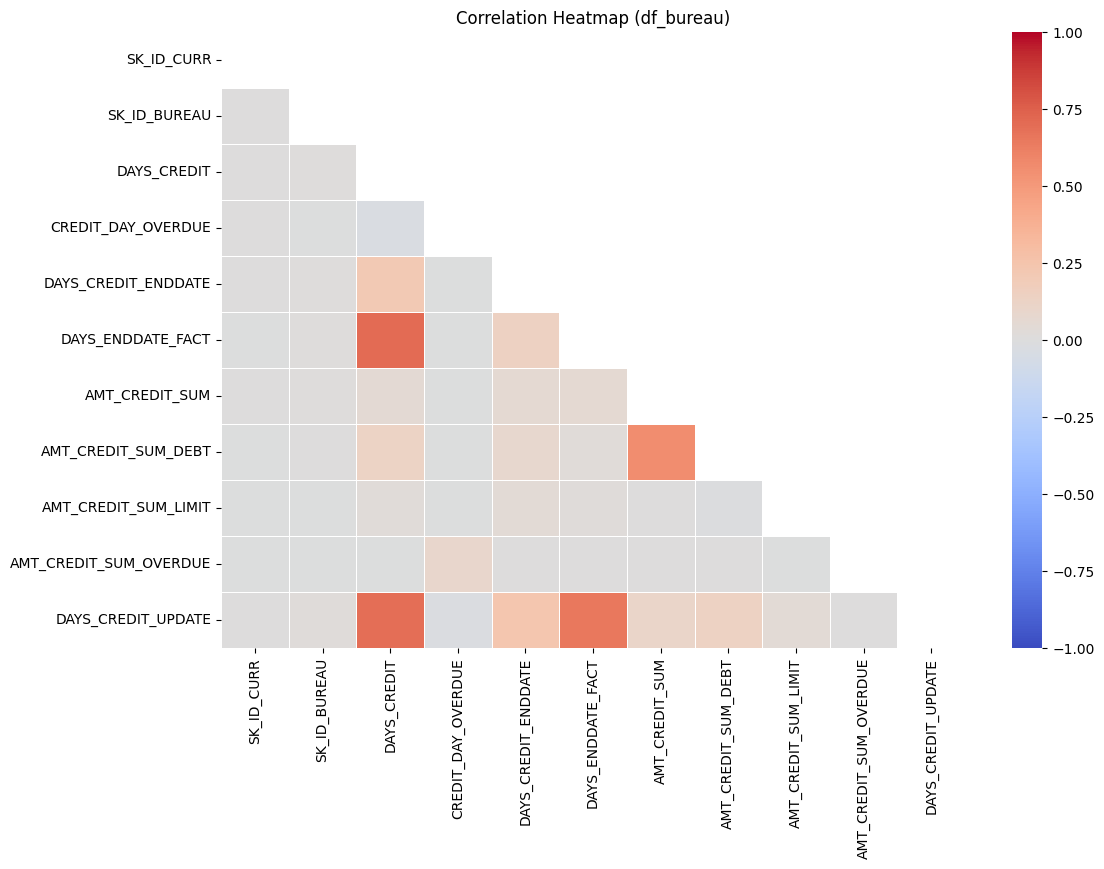

In [30]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False,
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1
)

# Title
plt.title("Correlation Heatmap (df_bureau)")
plt.show()

### Key Takeaways:
- **Strong correlation detected** between `DAYS_CREDIT`, `DAYS_ENDDATE_FACT`, and `DAYS_CREDIT_UPDATE` (suggesting potential redundancy).
- `AMT_CREDIT_SUM_DEBT` and `AMT_CREDIT_SUM` also show **moderate correlation**, meaning they may contain overlapping information.
- Features with very low correlations are unlikely to have linear relationships but may still be useful for non-linear models.
- Further feature selection may be required to avoid multicollinearity.

### 4.4 Visualizing Outliers  

We plot boxplots of key numerical features to detect **potential extreme values**.  
Since LightGBM handles outliers efficiently, **no transformations** are applied.  

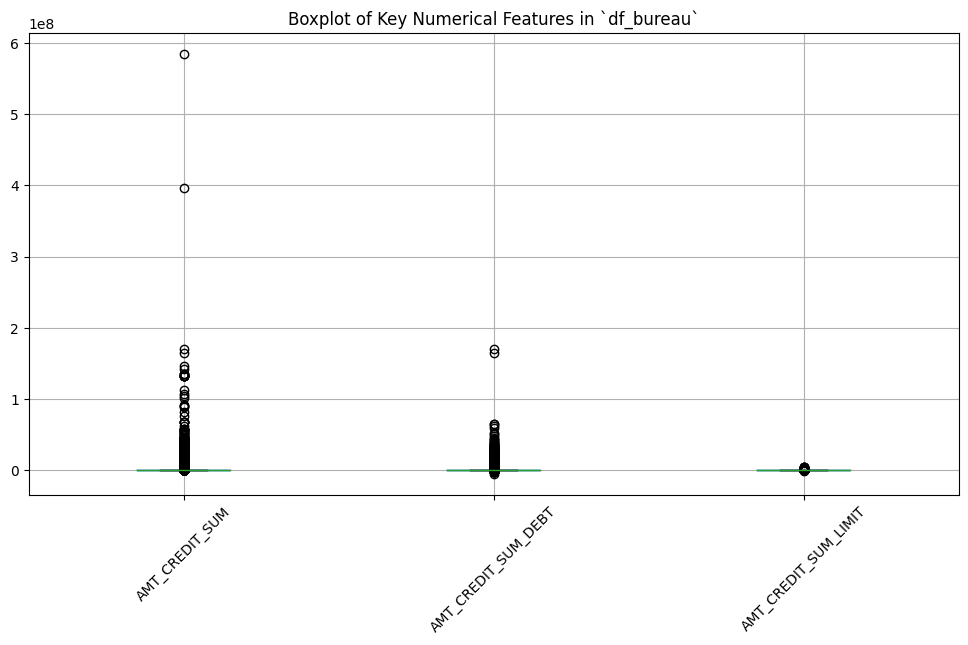

In [31]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_bureau[outlier_columns].boxplot()

# Title
plt.title("Boxplot of Key Numerical Features in `df_bureau`")
plt.xticks(rotation=45)  
plt.show()

### Key Takeaways:
- `AMT_CREDIT_SUM`, `AMT_CREDIT_SUM_DEBT`, and `AMT_CREDIT_SUM_LIMIT` contain **significant outliers** (large loan amounts).
- Despite extreme values, **no transformations will be applied**, as LightGBM is robust to outliers.
- These features might still require **scaling** if used in models sensitive to magnitude differences (e.g., linear models).

### 4.5 Pair Plot Analysis

Pair plots help visualize relationships between multiple numerical features.
- Scatter plots show relationships between feature pairs.
- Histograms along the diagonal show feature distributions.

To improve performance, we sample 10,000 rows from the dataset.

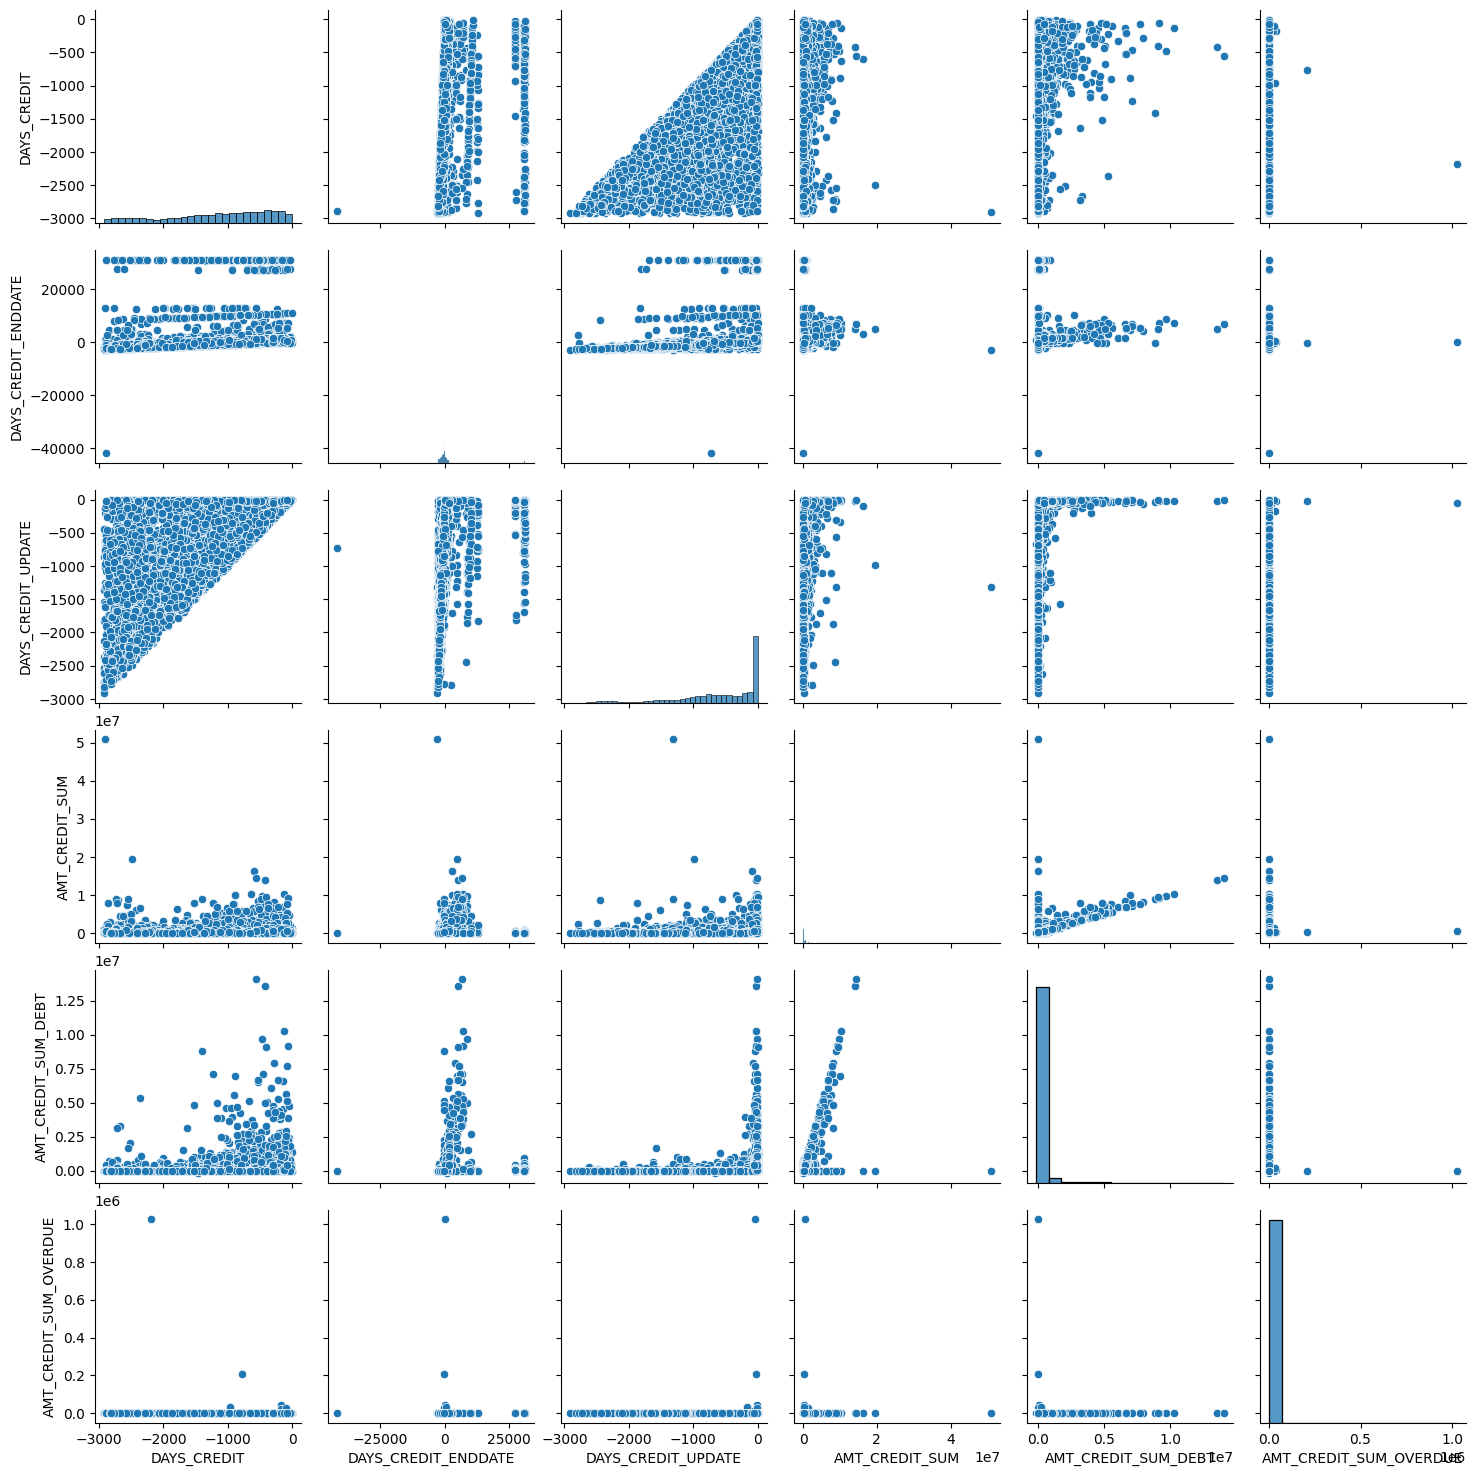

In [32]:
# Selected key numerical features for pair plot
numeric_features = [
    "DAYS_CREDIT", "DAYS_CREDIT_ENDDATE", "DAYS_CREDIT_UPDATE",
    "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE"
]

# Reduce dataset to 10,000 rows for performance
df_sample = df_bureau[numeric_features].sample(n=10000, random_state=42)

# Create pair plot
sns.pairplot(df_sample)
plt.show()

### Key Takeaways:
- **Linear relationship** detected between `DAYS_CREDIT`, `DAYS_ENDDATE_FACT`, and `DAYS_CREDIT_UPDATE`, confirming previous correlation findings.
- `AMT_CREDIT_SUM` and `AMT_CREDIT_SUM_DEBT` show **clustered patterns**, suggesting loan amounts are concentrated in specific value ranges.
- Some features have **skewed distributions**, which may require transformations depending on the model.
- There are **many zero values** in `AMT_CREDIT_SUM_OVERDUE`, possibly indicating missing data encoded as zeros.

### 4.6 Group-wise Analysis

Group-wise analysis helps us understand how numerical features vary across different categorical groups.
- We examine how a numerical feature is distributed across different categorical values.
- Boxplots are used to visualize variations and identify potential trends.
- This helps detect disparities and patterns that could be relevant for further modeling.

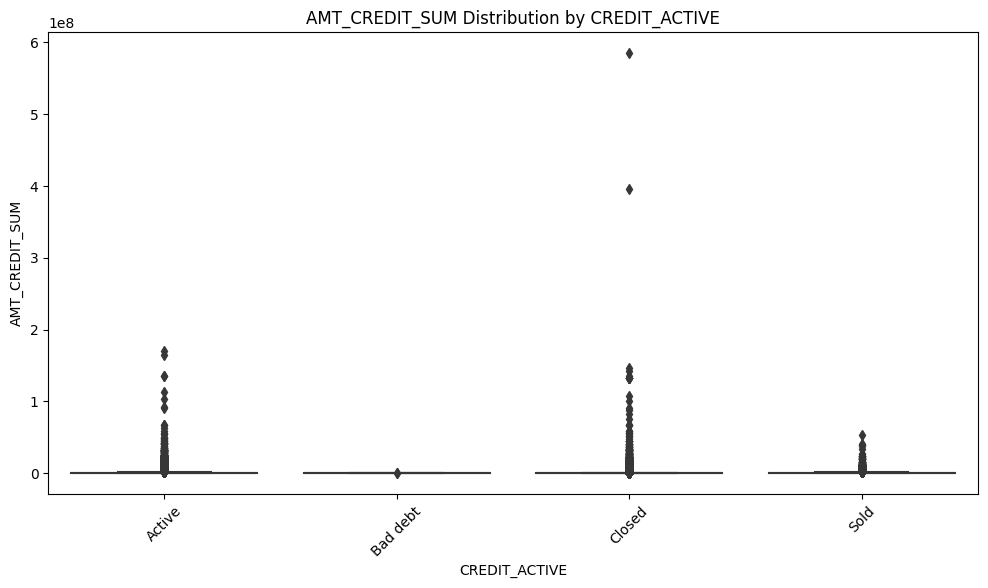

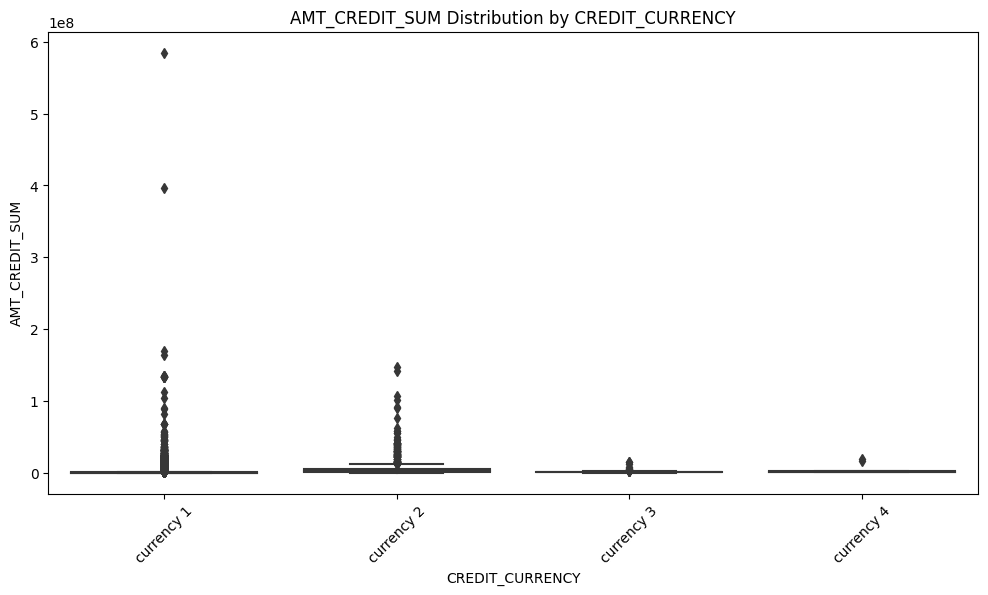

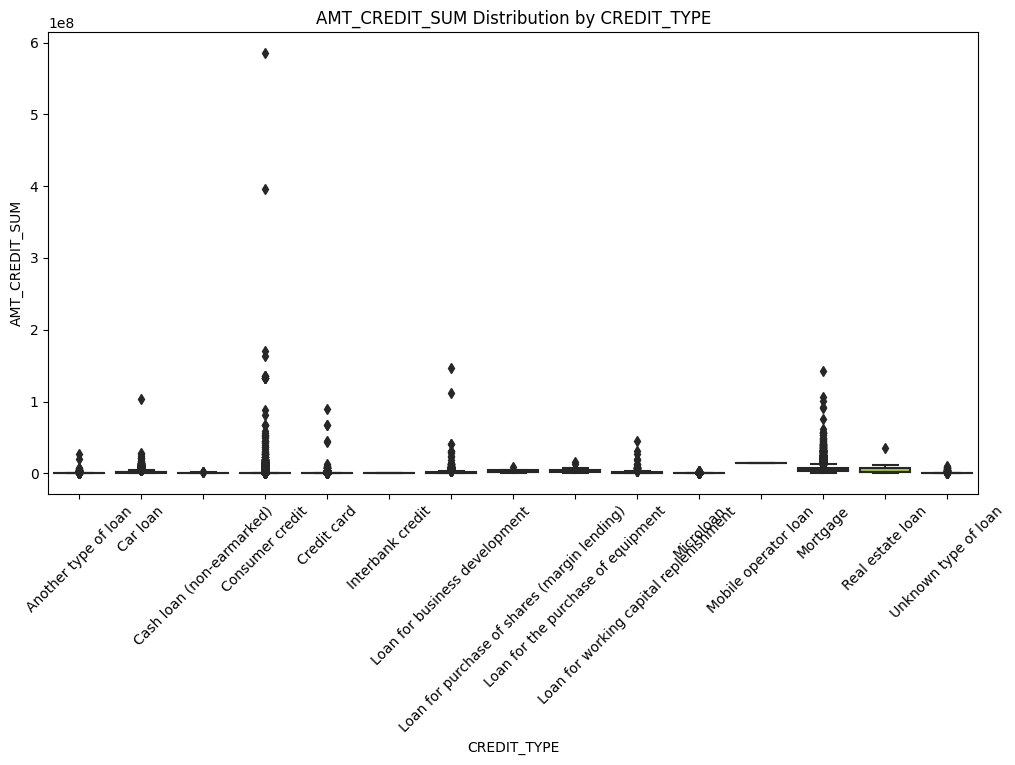

In [33]:
# Selected categorical columns for group-wise analysis
categorical_cols_boxplot = ["CREDIT_ACTIVE", "CREDIT_CURRENCY", "CREDIT_TYPE"]

# Selected numerical column (total credit amount)
numeric_col_boxplot = "AMT_CREDIT_SUM"

for column in categorical_cols_boxplot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y=numeric_col_boxplot, data=df_bureau, palette="viridis", dodge=False)
    plt.title(f"{numeric_col_boxplot} Distribution by {column}")
    plt.xticks(rotation=45)
    plt.show()

### Key Takeaways:
- **Credit Active Status (`CREDIT_ACTIVE`)**:  
  - Most loans are either "Active" or "Closed."
  - **Outliers** are present in "Closed" accounts, indicating large loan amounts previously paid off.  

- **Loan Currency (`CREDIT_CURRENCY`)**:  
  - Majority of loans are in "currency 1" and "currency 2."
  - Higher loan amounts tend to be in "currency 1," suggesting it may represent the local/national currency.  

- **Loan Type (`CREDIT_TYPE`)**:  
  - **Mortgage and real estate loans** have the **largest loan amounts**, as expected.
  - **Consumer credit and credit card loans** tend to have smaller amounts with some high outliers.
  - Other loan types, such as **mobile operator loans**, have very small values, possibly indicating short-term micro-loans.

- These insights can be useful for **feature engineering**, particularly if using models that require **outlier handling, encoding categorical features, or scaling numerical variables** (e.g., Logistic Regression, SVMs, Neural Networks).

### 4.7 Joint Plot Analysis
We use scatter plots with histograms to visualize relationships between numerical features.  
This helps identify patterns, correlations, and potential outliers.

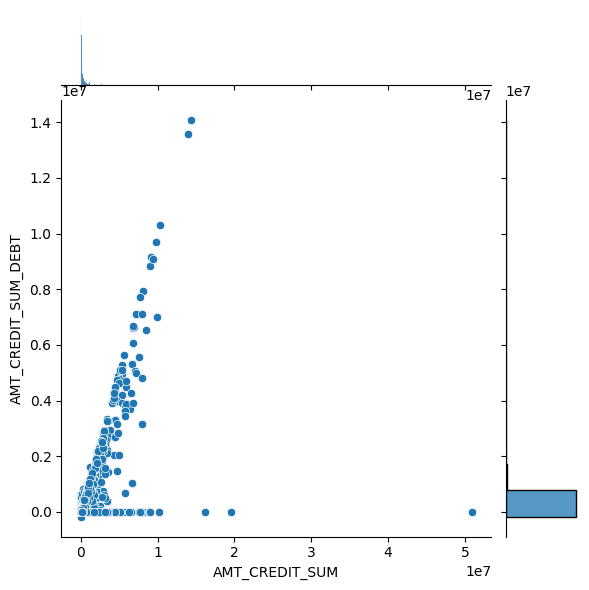

In [34]:
# Sample 10,000 rows for performance
df_sample_scatter = df_bureau.sample(n=10000, random_state=42)

# Scatter plot of Total Credit vs Outstanding Debt
sns.jointplot(x="AMT_CREDIT_SUM", y="AMT_CREDIT_SUM_DEBT", data=df_sample_scatter, kind="scatter")

plt.show()

### Key Takeaways:
- The majority of loans have **low total credit and low outstanding debt**.
- A small number of loans have **high credit amounts but little to no debt**, indicating they may be fully repaid.
- **Strong clustering at lower values** suggests most applicants take small loans.
- **Outliers** exist in high credit amounts, but they are rare.

### 4.8 Additional EDA Visualisations

We plot histograms to visualize the distribution of key numerical features.  
This helps detect skewness, outliers, and possible data transformations.

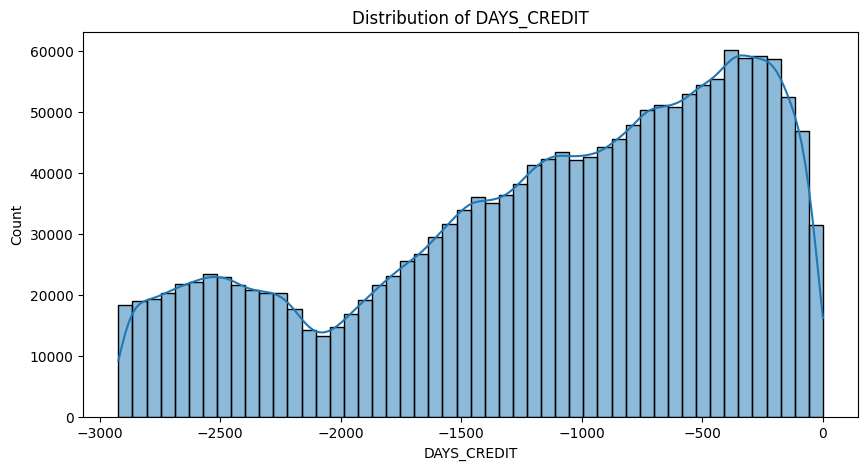

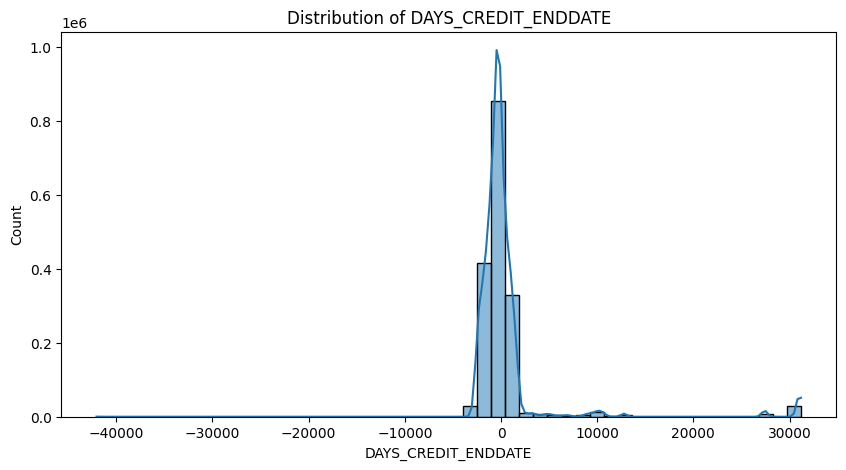

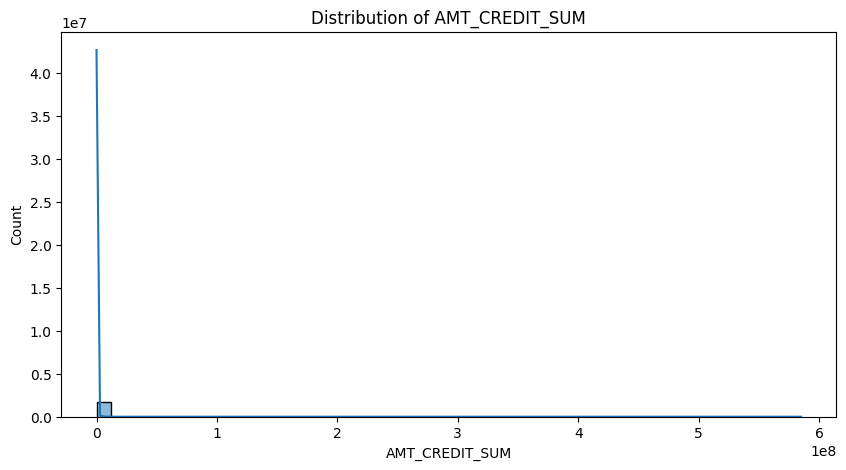

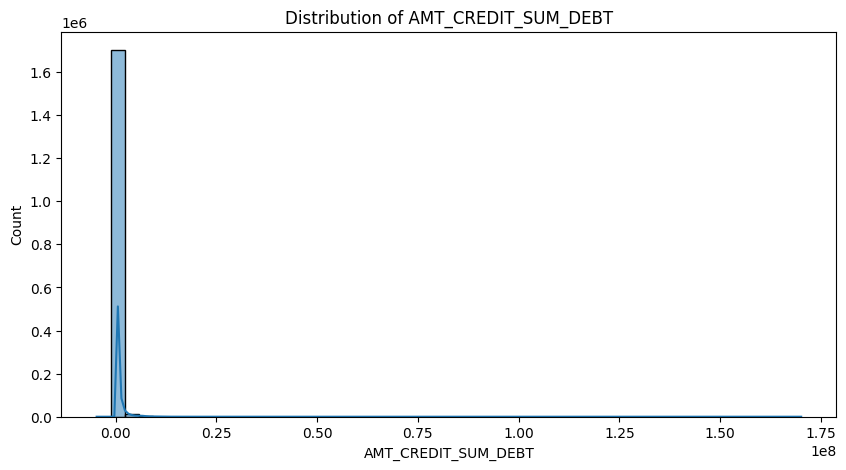

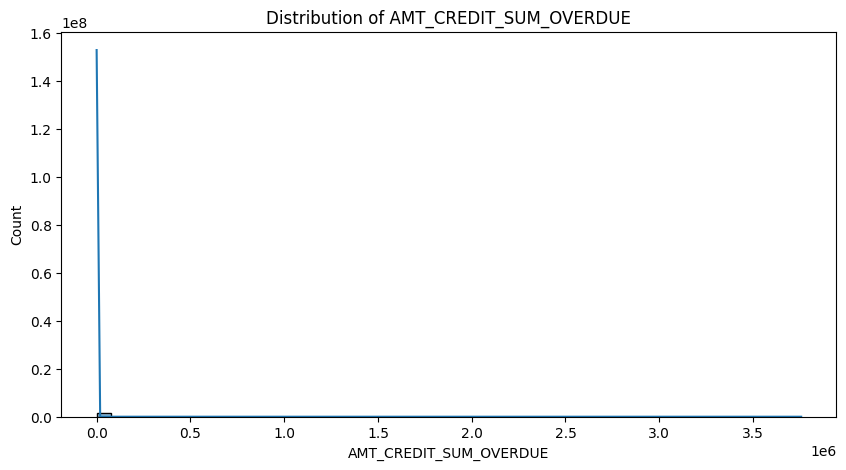

In [35]:
# List of key numerical features to check distributions
features_to_plot = [
    "DAYS_CREDIT", "DAYS_CREDIT_ENDDATE", "AMT_CREDIT_SUM", 
    "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE"
]

# Plot histograms for selected features
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_bureau[feature], bins=50, kde=True)  
    plt.title(f"Distribution of {feature}")
    plt.show()

### Key Takeaways:
- `DAYS_CREDIT` and `DAYS_CREDIT_ENDDATE` have **left-skewed distributions**, confirming that most credit accounts were opened or closed recently.
- `AMT_CREDIT_SUM`, `AMT_CREDIT_SUM_DEBT`, and `AMT_CREDIT_SUM_OVERDUE` have **extreme outliers**, making the plots hard to interpret.
  - The majority of loans are **small**, but a few **high-value loans dominate the scale**.
  - This suggests that log transformations could be useful for models that are sensitive to scale.
- The spike at zero in `AMT_CREDIT_SUM_OVERDUE` suggests that **most applicants have no overdue debt**, making it a possible binary indicator.

We analyze the distribution of key categorical features using bar plots.  
This helps identify class imbalances, dominant categories, and rare values.

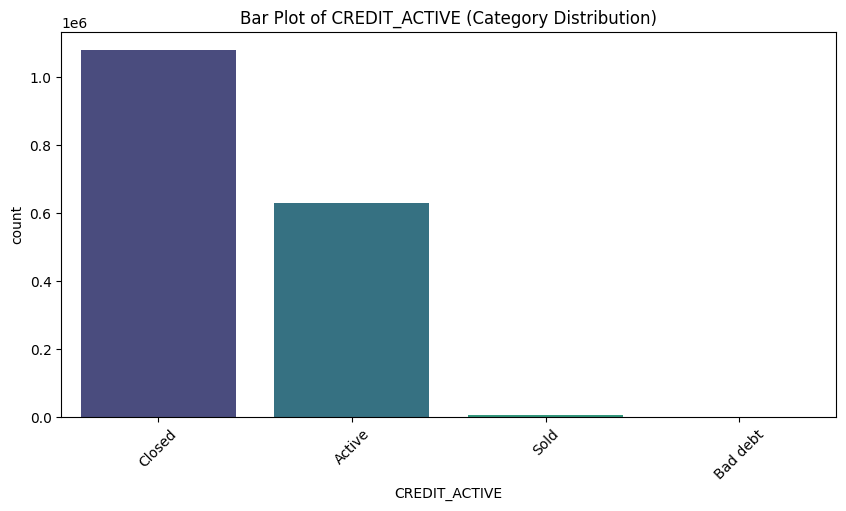

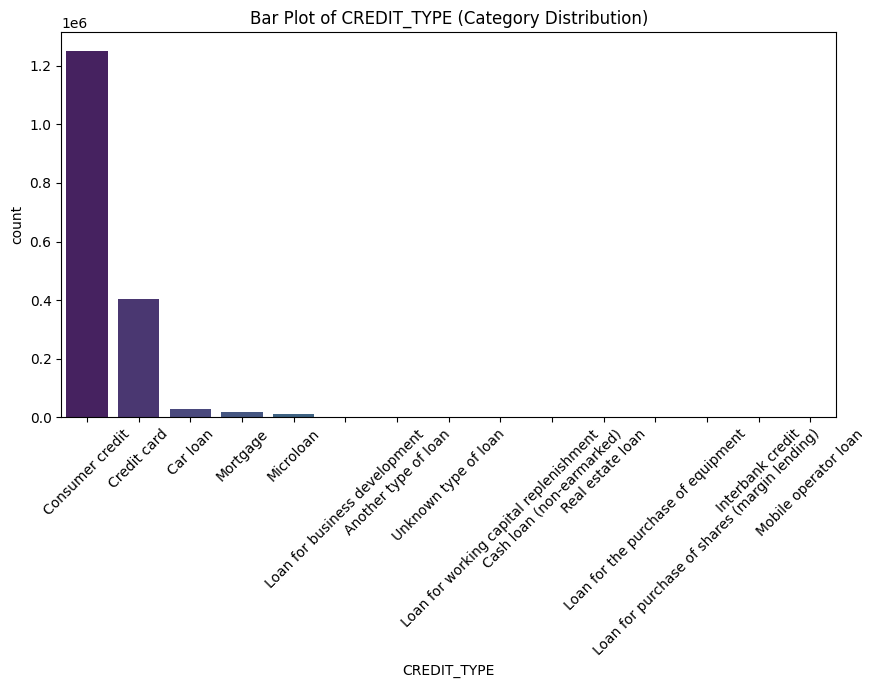

In [36]:
categorical_features_barplot = ["CREDIT_ACTIVE", "CREDIT_TYPE"]

for feature in categorical_features_barplot:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df_bureau[feature], order=df_bureau[feature].value_counts().index, palette="viridis")
    plt.title(f"Bar Plot of {feature} (Category Distribution)")
    plt.xticks(rotation=45)
    plt.show()

### Key Takeaways:
- `CREDIT_ACTIVE` shows that **most credit accounts are closed**, while active accounts make up a smaller share.
  - Very few accounts are labeled as "Sold" or "Bad debt."
- `CREDIT_TYPE` is **highly imbalanced**, with **Consumer Credit and Credit Cards dominating**.
  - Other loan types (e.g., mortgages, microloans) appear much less frequently.
  - Some rare loan types exist, which may require grouping or handling for modeling.

## 5. Feature Engineering (`bureau.csv`)
We create new features to enhance predictive power by summarizing key attributes of the dataset.  
Feature engineering helps capture meaningful patterns that might improve model performance.

### 5.1 Credit Activity Features  
These features count the number of loans per client, distinguishing between different statuses.

In [37]:
# Group by SK_ID_CURR and calculate loan counts
bureau_credit_activity = df_bureau.groupby("SK_ID_CURR").agg(
    bureau_NUM_LOANS=("SK_ID_BUREAU", "count"),  # Total number of loans per client
    bureau_NUM_ACTIVE_LOANS=("CREDIT_ACTIVE", lambda x: (x == "Active").sum()),  # Count active loans
    bureau_NUM_CLOSED_LOANS=("CREDIT_ACTIVE", lambda x: (x == "Closed").sum())  # Count closed loans
).reset_index()

# Preview the new features before merging
display(bureau_credit_activity.head())

,SK_ID_CURR,bureau_NUM_LOANS,bureau_NUM_ACTIVE_LOANS,bureau_NUM_CLOSED_LOANS
0,100001,7,3,4
1,100002,8,2,6
2,100003,4,1,3
3,100004,2,0,2
4,100005,3,2,1


### 5.2 Loan Amount Features
Summarizes total credit amounts, outstanding debts, and debt-to-credit ratios for each client.

In [38]:
# Group by SK_ID_CURR and calculate credit-related statistics
bureau_loan_amounts = df_bureau.groupby("SK_ID_CURR").agg(
    bureau_TOTAL_CREDIT_AMOUNT=("AMT_CREDIT_SUM", "sum"),  # Total credit amount per client
    bureau_AVG_CREDIT_AMOUNT=("AMT_CREDIT_SUM", "mean"),  # Average credit amount per loan
    bureau_TOTAL_DEBT=("AMT_CREDIT_SUM_DEBT", "sum")  # Total outstanding debt per client
).reset_index()

# Compute Debt-to-Credit Ratio (Avoid division by zero)
bureau_loan_amounts["bureau_DEBT_CREDIT_RATIO"] = bureau_loan_amounts["bureau_TOTAL_DEBT"] / bureau_loan_amounts["bureau_TOTAL_CREDIT_AMOUNT"]
bureau_loan_amounts["bureau_DEBT_CREDIT_RATIO"] = bureau_loan_amounts["bureau_DEBT_CREDIT_RATIO"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Preview the new features before merging
display(bureau_loan_amounts.head())

,SK_ID_CURR,bureau_TOTAL_CREDIT_AMOUNT,bureau_AVG_CREDIT_AMOUNT,bureau_TOTAL_DEBT,bureau_DEBT_CREDIT_RATIO
0,100001,1453365.000,207623.571429,596686.5,0.410555
1,100002,865055.565,108131.945625,245781.0,0.284122
2,100003,1017400.500,254350.125000,0.0,0.000000
3,100004,189037.800,94518.900000,0.0,0.000000
4,100005,657126.000,219042.000000,568408.5,0.864992


### 5.3 Time-Based Features
Calculates time-related loan statistics such as average loan age.

In [39]:
# Group by SK_ID_CURR and calculate time-related statistics
bureau_time_features = df_bureau.groupby("SK_ID_CURR").agg(
    bureau_AVG_CREDIT_AGE=("DAYS_CREDIT", lambda x: abs(x.mean()) / 365),  # Average loan age in years
    bureau_TIME_SINCE_LAST_UPDATE=("DAYS_CREDIT_UPDATE", lambda x: abs(x.max()) / 365),  # Time since last update
    bureau_AVG_REMAINING_CREDIT_TIME=("DAYS_CREDIT_ENDDATE", lambda x: abs(x.mean()) / 365)  # Remaining credit time
).reset_index()

# Preview the new features before merging
display(bureau_time_features.head())

,SK_ID_CURR,bureau_AVG_CREDIT_AGE,bureau_TIME_SINCE_LAST_UPDATE,bureau_AVG_REMAINING_CREDIT_TIME
0,100001,2.013699,0.016438,0.225832
1,100002,2.394521,0.019178,0.943151
2,100003,3.837671,0.117808,1.491781
3,100004,2.375342,1.046575,1.338356
4,100005,0.522374,0.030137,1.203653


### 5.4 Credit Overdue Features
Captures overdue loan amounts and the number of overdue accounts per client.

In [40]:
# Group by SK_ID_CURR and calculate overdue-related statistics
bureau_overdue_features = df_bureau.groupby("SK_ID_CURR").agg(
    bureau_NUM_OVERDUE_LOANS=("CREDIT_DAY_OVERDUE", lambda x: (x > 0).sum()),  # Count overdue loans
    bureau_TOTAL_OVERDUE_AMOUNT=("AMT_CREDIT_SUM_OVERDUE", "sum")  # Total overdue amount
).reset_index()

# Preview the new features before merging
display(bureau_overdue_features.head())

,SK_ID_CURR,bureau_NUM_OVERDUE_LOANS,bureau_TOTAL_OVERDUE_AMOUNT
0,100001,0,0.0
1,100002,0,0.0
2,100003,0,0.0
3,100004,0,0.0
4,100005,0,0.0


### 5.5 Categorical Features Aggregation
Extracts insights from categorical variables, such as the most common credit type and percentage of active loans.

In [41]:
# Compute percentage of active loans and most common credit type
bureau_categorical_features = df_bureau.groupby("SK_ID_CURR").agg(
    bureau_PERCENT_ACTIVE=("CREDIT_ACTIVE", lambda x: (x == "Active").sum() / len(x)),  # Percentage of active loans
    bureau_MOST_COMMON_CREDIT_TYPE=("CREDIT_TYPE", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),  # Most common loan type
    bureau_HAS_BAD_DEBT=("CREDIT_ACTIVE", lambda x: 1 if (x == "Bad debt").any() else 0)  # Binary flag for bad debt history
).reset_index()

# Preview the new features before merging
display(bureau_categorical_features.head())

,SK_ID_CURR,bureau_PERCENT_ACTIVE,bureau_MOST_COMMON_CREDIT_TYPE,bureau_HAS_BAD_DEBT
0,100001,0.428571,Consumer credit,0
1,100002,0.250000,Consumer credit,0
2,100003,0.250000,Consumer credit,0
3,100004,0.000000,Consumer credit,0
4,100005,0.666667,Consumer credit,0


## 6. Aggregation (`bureau.csv`)
We aggregate numerical and categorical features at the client level to summarize loan-related patterns. This reduces dataset size while retaining essential information.

### 6.1 Aggregate All Numeric and Categorical Columns
- Numerical features are aggregated using mean, sum, max, and min to capture overall trends.
- Categorical features are aggregated using the most frequent category per client.

This step ensures that client-level insights are preserved for modeling while reducing redundancy.

In [42]:
# 🔹 Aggregate df_bureau before merging
print("\nAggregating df_bureau by SK_ID_CURR...")

# Exclude SK_ID_BUREAU (loan-level unique identifier)
agg_numeric_columns = df_bureau.select_dtypes(include=['number']).drop(columns=['SK_ID_BUREAU'], errors='ignore')

# 🔹 Aggregate numerical features (without std)
agg_funcs = ['mean', 'sum', 'max', 'min']  # Removed 'std' for cleaner results
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['bureau_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# 🔹 Optimize categorical feature aggregation
agg_categorical_columns = df_bureau.select_dtypes(include=['object', 'category']).drop(columns=['SK_ID_BUREAU'], errors='ignore')

if not agg_categorical_columns.empty:
    # Instead of mode(), use value_counts().idxmax() for speed
    agg_categorical_columns = df_bureau[['SK_ID_CURR']].join(agg_categorical_columns)
    
    agg_categorical = agg_categorical_columns.groupby('SK_ID_CURR').agg(lambda x: x.value_counts().idxmax() if not x.empty else "Unknown")
    agg_categorical.columns = ['bureau_agg_' + col + '_most_frequent' for col in agg_categorical.columns]
    agg_categorical.reset_index(inplace=True)

    # Merge aggregated numerical and categorical features
    df_bureau_aggregated = agg_numeric.merge(agg_categorical, on="SK_ID_CURR", how="left")
else:
    df_bureau_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_bureau_aggregated shape: {df_bureau_aggregated.shape}")


Aggregating df_bureau by SK_ID_CURR...
✅ Aggregation complete. New df_bureau_aggregated shape: (305811, 41)


## 7. Merging (`bureau.csv`)
We merge all newly created feature tables into a single dataset using a **left join on SK_ID_CURR**.  
This ensures that no client records are lost while incorporating the engineered features.


In [43]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    print(f"⚠️ Missing Values in {name} After Merge:\n{df_main.isnull().sum()[df_main.isnull().sum() > 0]}")
    print("-" * 50)

    return df_main

# Apply Safe Merges at the End
df_bureau_aggregated = safe_merge(df_bureau_aggregated, bureau_credit_activity, name="bureau_credit_activity")
df_bureau_aggregated = safe_merge(df_bureau_aggregated, bureau_loan_amounts, name="bureau_loan_amounts")
df_bureau_aggregated = safe_merge(df_bureau_aggregated, bureau_time_features, name="bureau_time_features")
df_bureau_aggregated = safe_merge(df_bureau_aggregated, bureau_overdue_features, name="bureau_overdue_features")
df_bureau_aggregated = safe_merge(df_bureau_aggregated, bureau_categorical_features, name="bureau_categorical_features")

print("✅ All feature tables merged successfully!")

✅ Merged bureau_credit_activity: (305811, 41) -> (305811, 44)
⚠️ Missing Values in bureau_credit_activity After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_loan_amounts: (305811, 44) -> (305811, 48)
⚠️ Missing Values in bureau_loan_amounts After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_time_features: (305811, 48) -> (305811, 51)
⚠️ Missing Values in bureau_time_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_overdue_features: (305811, 51) -> (305811, 53)
⚠️ Missing Values in bureau_overdue_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_categorical_features: (305811, 53) -> (305811, 56)
⚠️ Missing Values in bureau_categorical_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ All feature tables me

### 7.1 Feature Validation
Before saving, we validate the dataset by checking for:  
- **Missing values** (standard NaNs and hidden NaNs stored as text)  
- **Infinite values** (Inf or -Inf, which can cause issues in modeling)  

Once verified, the aggregated dataset is saved.

In [44]:
# Step 1: Check for standard NaN values
missing_values_bureau_aggregated = df_bureau_aggregated.isna().sum()
missing_values_bureau_aggregated = missing_values_bureau_aggregated[missing_values_bureau_aggregated > 0]
print("\nStandard Missing Values in Aggregated Bureau Features After Merging:")
print(missing_values_bureau_aggregated if not missing_values_bureau_aggregated.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string)
hidden_nans_bureau_aggregated = (df_bureau_aggregated == "").sum() + (df_bureau_aggregated == "nan").sum()
hidden_nans_bureau_aggregated = hidden_nans_bureau_aggregated[hidden_nans_bureau_aggregated > 0]
print("\nHidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Bureau Features After Merging:")
print(hidden_nans_bureau_aggregated if not hidden_nans_bureau_aggregated.empty else "✅ No hidden NaNs detected.")


Standard Missing Values in Aggregated Bureau Features After Merging:
✅ No standard NaN values detected.

Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Bureau Features After Merging:
✅ No hidden NaNs detected.


In [45]:
# Step 3: Check for Inf values
inf_values_bureau_aggregated = df_bureau_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_bureau_aggregated = inf_values_bureau_aggregated[inf_values_bureau_aggregated > 0]

print("\nInfinite Values in Aggregated Bureau Features AFter Merging:")
if inf_values_bureau_aggregated.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_bureau_aggregated)


Infinite Values in Aggregated Bureau Features AFter Merging:
✅ No Inf values detected.


In [46]:
df_bureau_aggregated.to_csv("bureau_aggregated.csv", index=False)
df_bureau_aggregated.to_pickle("bureau_aggregated.pkl")
print("✅ Bureau aggregated dataset saved successfully!")


✅ Bureau aggregated dataset saved successfully!
